# Probing Density

In [7]:
import matplotlib.pyplot as plt
import random
import numpy as np
random.seed(1337)

On a 1-dimensional interval [0,1] there exists $n$ points. We know nothing the distribution of dots or how many of them there are. However, we do know that there's a minimum distance $d$ between the dots. This is given to us as prior information.

We have one tool to our disposal: a probe. We can give the probe a position $x \in [0,1]$ and it will return the coordinates to the closest left and right dots. We define it as $probe(x): x \in [0,1] \rightarrow (l,r)$ where $l,r \in [0,1]$.

Our task is to approximate the number of dots that's present in the interval. Remember that we can assume nothing about the distribution of dots, as they are placed *arbitrarily*.

### The Probe Function
The probe function looks through the list of (sorted) generated dots and finds the dots left and right of the probed position.

In [2]:
def probe(x, dots):
    N = len(dots)
    for i, dot in enumerate(dots[:-1]):
        if x > dot:
            continue
        else:
            if i - 1 < 0:
                l = None
                r = dots[i]
            else:
                l = dots[i]
                r = dots[i+1]

            return (l,r)
            
    # If we get to the end there's no dots left of x
    return (dots[-1], None)

## The Intervals

Let's visualize the interval with dots by placing 100 dots in a random fashion. With the contraint that a point cannot be closer than $d$ from any other point. We'll set $d = 0.05$ for now 

In [161]:
N = 100
d = 0.001
def generate_dots(N, d, distribution_fn):
    dots = []
    for i in range(N):
        # not the most efficient but will do for now
        dots.sort()

        if len(dots) < 1:
            x = distribution_fn()
            dots.append(x)
            continue
        
        too_close = True
        while too_close:
            x = distribution_fn()
            too_close = False
            for dot in dots:
                if abs(x - dot) < d:
                    too_close = True
                    break
            
            if not too_close:
                dots.append(x)

    return dots

In [162]:
def plot_interval(dots, title='Our beautiful interval'):
    N = len(dots)
    y = [0 for i in range(N)]
    plt.figure(figsize=(20,8))
    plt.hlines(0,0,1, alpha=0.3)
    plt.scatter(dots, y, s=50, facecolors='none', edgecolors='r', label='N = %d' % (N))
    plt.title(title)
    plt.legend()
    plt.show()

### Uniform Interval

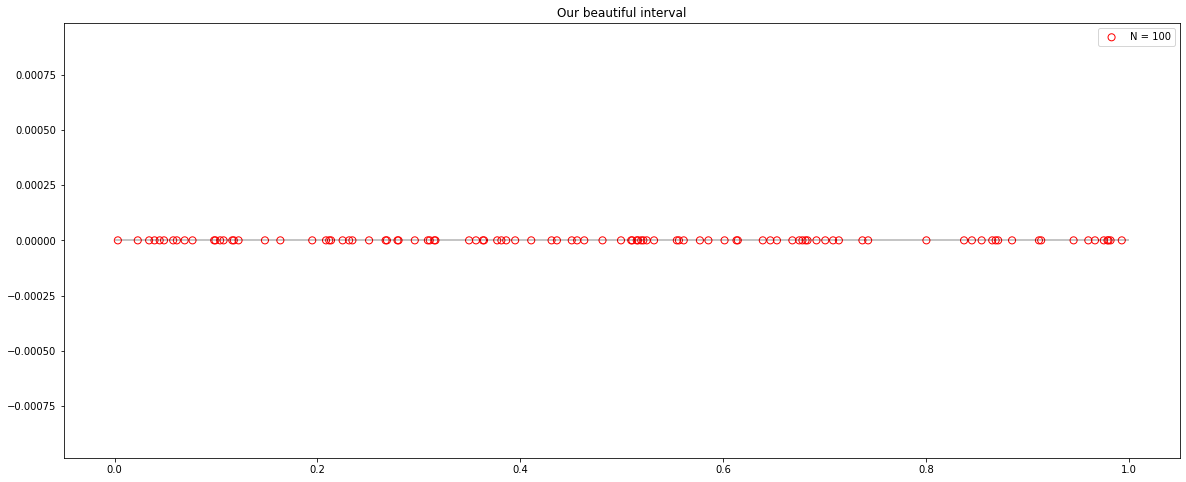

In [163]:
def custom_randunif():
    return random.uniform(0,1)

dots = generate_dots(N,d, custom_randunif)
dots.sort()
plot_interval(dots)


Let's double check that the generated points follow the distance constraint:

In [164]:
dts = np.array(dots)
dts2 = np.roll(np.copy(dts), -1)
diff = np.abs(dts-dts2)
diff = diff[:-1]
min_dist = diff.min()
max_dist = diff.max()
print("Min distance: %.6f" % min_dist)
print("Max distance: %.6f" % max_dist)

Min distance: 0.001005
Max distance: 0.057446


### Gaussian Interval

Let's make an interval with normally distributed points

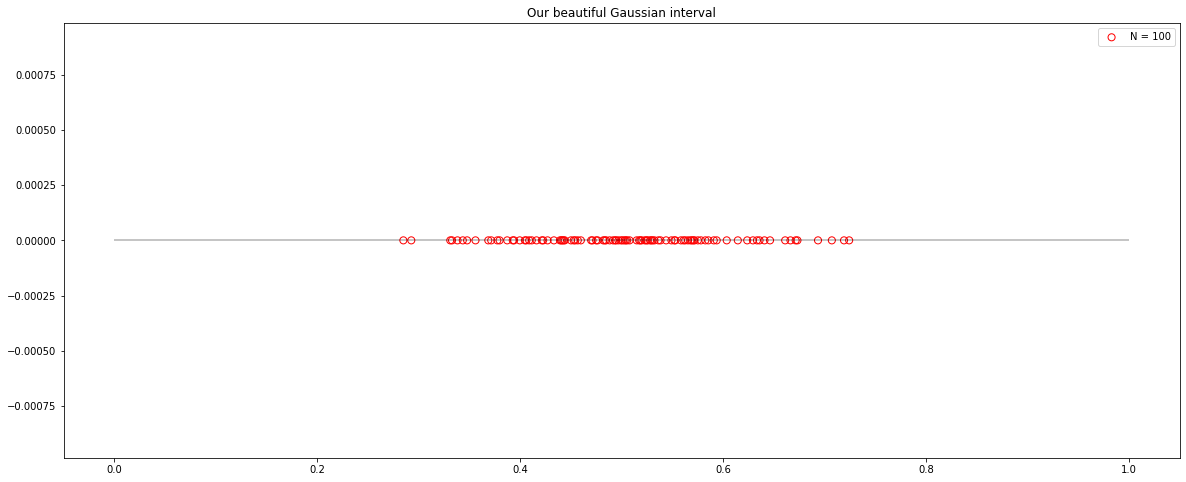

In [165]:
def custom_gaussian():
    return random.gauss(0.5, 0.1)

dots_gauss = generate_dots(N,d, custom_gaussian)
plot_interval(dots_gauss, "Our beautiful Gaussian interval")
dots_gauss.sort()

### Clusters Interval

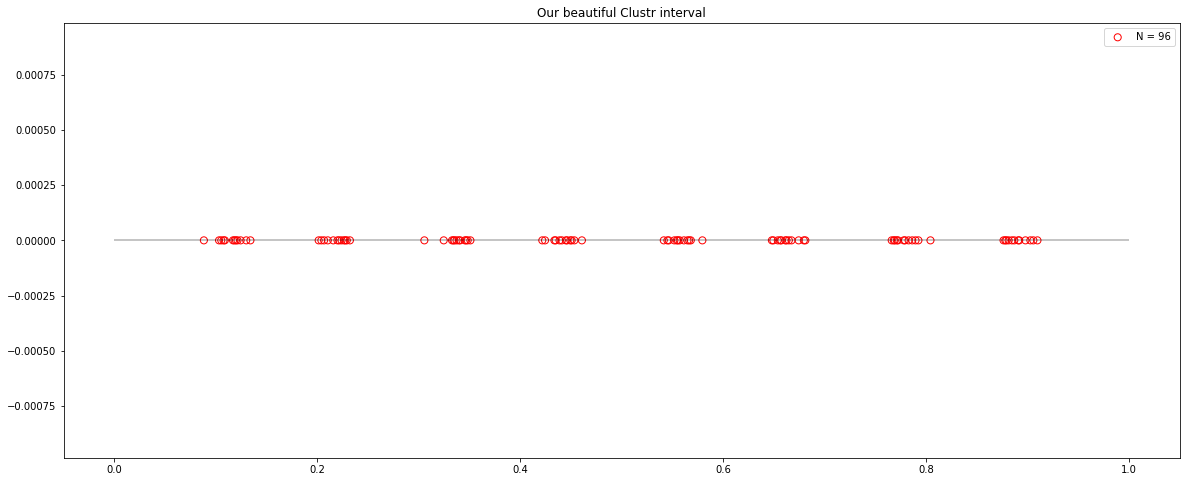

In [175]:
num_clusters = 8
std = 0.01
mu_range = np.arange(0,1,1/(num_clusters+1))
mu_range = mu_range[1:]
dots_clustrs = []
for i in range(num_clusters):
    def custom_clustrs():
        return random.gauss(mu_range[i], std)
        generate_dots(N//num_clusters,d, custom_clustrs1)

    clust = generate_dots(N//num_clusters,d, custom_clustrs)
    dots_clustrs.append(clust)

dots_clustrs = np.array(dots_clustrs).flatten()

plot_interval(dots_clustrs, "Our beautiful Clustr interval")
dots_clustrs.sort()

## A Simple Randomized Approach

One metric is the mean distance between points, $\bar{d}$. The inverse of $\bar{d}$ can be used to approximate the number of points $\bar{n} = 1 / \bar{d}$. 

One approach is to simply probe the line $k$ times and try to get a mean distance between the dots.

In [176]:
import numpy as np

def simple_probing(dots, k, a, b):
    distances = []
    
    for i in range(k):
        x = random.uniform(a,b)
        l,r = probe(x, dots)
        # For now we skip edges
        if l and r:
            d = r - l
            distances.append(d)

    if len(distances):
        dists = np.array(distances)
        d_mean = dists.mean()
        return 1 / d_mean
    else:
        return 0


Let's run the simple probing algorithm and see some approximations

### Simple Randomized Approach on Uniform Interval

In [201]:
approximations = []
for i in range(100):
    n_approx = simple_probing(dots, 1000, 0, 1)
    approximations.append(n_approx)

aprx = np.array(approximations)
sd_mean = aprx.mean();
sd_std = aprx.std();
print("Sample Distribution Mean: %.2f" % sd_mean)
print("Sample Distribution STD: %.2f" % sd_std)

Sample Distribution Mean: 91.27
Sample Distribution STD: 2.86


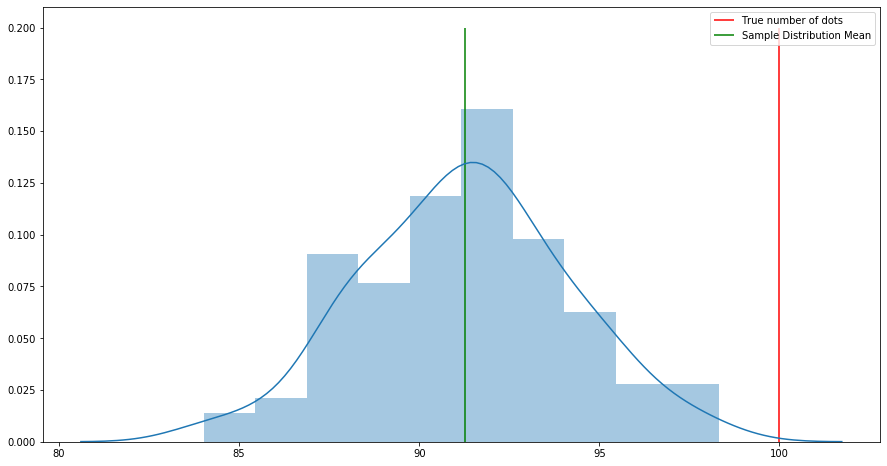

In [203]:
import seaborn as sns
def plot_sample_dist(aprx, N):
    plt.figure(figsize=(15,8))
    line_height = 0.2
    sns.distplot(aprx);
    plt.vlines(N, 0, line_height, colors='r', label='True number of dots')
    plt.vlines(aprx.mean(), 0, line_height, colors='g', label='Sample Distribution Mean')
    plt.legend()
    plt.show()

plot_sample_dist(aprx, N)

Looks pretty neat! The barplot makes it look like we're ways off, but in reality we are not.

#### Error Rate as we increase N

In [283]:
def test_error_rate(random_fn):
    err_runs = 10
    Ns = [50, 100, 200, 500, 1000, 2000]
    relative_err_means = []
    relative_err_std = []
    for n in Ns:
        print("Testing %d dots..." % (n))
        rel_errs = []
        for i_run in range(err_runs):
            d_n = (1 / n) * 0.01
            approximations = []
            dots_n = generate_dots(n,d_n, random_fn)
            dots_n.sort()

            for i in range(100):
                n_approx = simple_probing(dots_n, 1000, 0, 1)
                approximations.append(n_approx)

            aprx = np.array(approximations)
            sd_mean = aprx.mean();
            sd_std = aprx.std();
            rel_errs.append(abs(sd_mean-n)/n)

        errs_np = np.array(rel_errs)
        relative_err_means.append(errs_np.mean())
        relative_err_std.append(errs_np.std())
        print("On average the approximation error is: %.4f %%" % (errs_np.mean() * 100))
        print("The error deviates with: %.4f %%\n" % (errs_np.std()*100))
        
    return Ns, relative_err_means, relative_err_std

In [284]:
Ns, relative_err_means, relative_err_std = test_error_rate(custom_randunif)

Testing 50 dots...
On average the approximation error is: 10.8627 %
The error deviates with: 6.7546 %

Testing 100 dots...
On average the approximation error is: 10.1319 %
The error deviates with: 7.9767 %

Testing 200 dots...
On average the approximation error is: 5.5323 %
The error deviates with: 3.5584 %

Testing 500 dots...
On average the approximation error is: 6.6654 %
The error deviates with: 3.5778 %

Testing 1000 dots...
On average the approximation error is: 2.6243 %
The error deviates with: 1.9533 %

Testing 2000 dots...
On average the approximation error is: 0.9295 %
The error deviates with: 0.6242 %



In [301]:
def plot_error_rate(Ns, relative_err_means, relative_err_std, title='% Error vs N'):
    plt.figure(figsize=(15,8))
    plt.errorbar(Ns, np.array(relative_err_means)*100, yerr=np.array(relative_err_std)*100, capsize=4, ecolor='r',
                label='Error std')
    plt.xlabel('Number of dots')
    plt.ylabel('% Error')
    plt.legend()
    plt.title(title)
    plt.show()

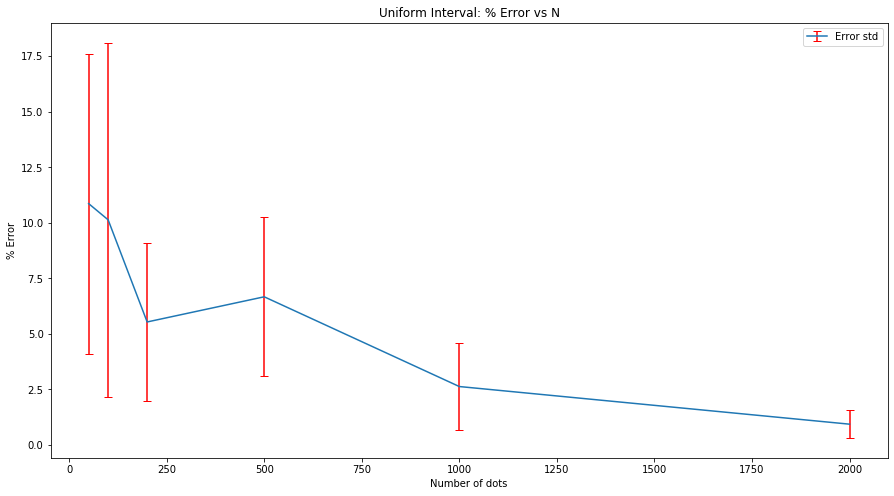

In [302]:
plot_error_rate(Ns, relative_err_means, relative_err_std, title='Uniform Interval: % Error vs N')

In [278]:
relative_err_means

[0.09160939506147599,
 0.08762464139069717,
 0.04136539136113278,
 0.030295486683512184,
 0.026992772213881532,
 0.014798689427919749]

### Simple Randomized Approach on Gaussian dots

Sample Distribution Mean: 182.97
Sample Distribution STD: 9.45


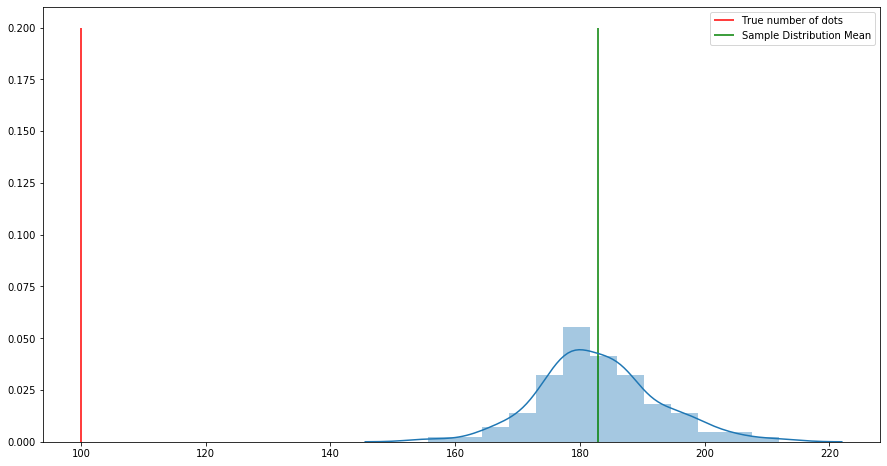

In [192]:
approximations = []
for i in range(100):
    n_approx = simple_probing(dots_gauss, 1000, 0, 1)
    approximations.append(n_approx)

aprx = np.array(approximations)
sd_mean = aprx.mean();
sd_std = aprx.std();
print("Sample Distribution Mean: %.2f" % sd_mean)
print("Sample Distribution STD: %.2f" % sd_std)
plot_sample_dist(aprx, N)

Oh well, this did now work very well

#### Testing the error rate on gaussian interval

Testing 50 dots...
On average the approximation error is: 13.9743 %
The error deviates with: 14.5224 %

Testing 100 dots...
On average the approximation error is: 5.0407 %
The error deviates with: 3.8202 %

Testing 200 dots...
On average the approximation error is: 5.9532 %
The error deviates with: 3.8273 %

Testing 500 dots...
On average the approximation error is: 4.9126 %
The error deviates with: 3.8386 %

Testing 1000 dots...
On average the approximation error is: 2.9082 %
The error deviates with: 1.2165 %

Testing 2000 dots...
On average the approximation error is: 2.5863 %
The error deviates with: 2.2326 %



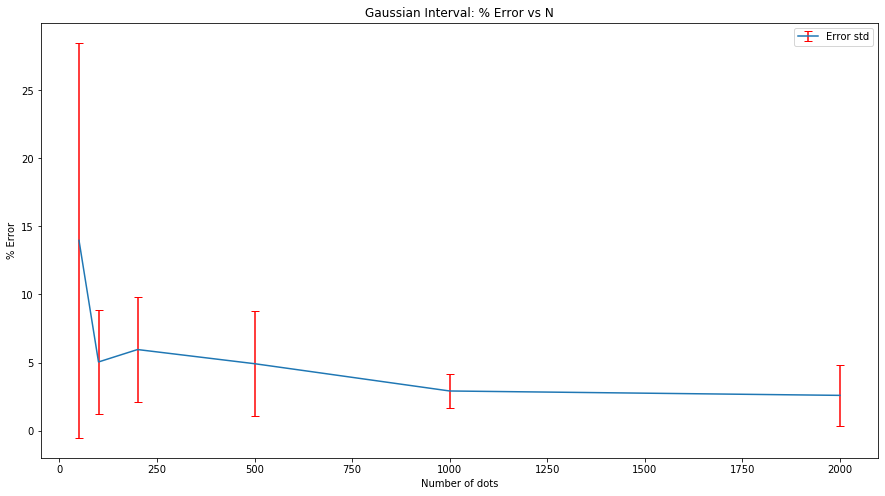

In [303]:
Ns, relative_err_means, relative_err_std = test_error_rate(custom_randunif)
plot_error_rate(Ns, relative_err_means, relative_err_std, title='Gaussian Interval: % Error vs N')

### Simple Randomized Approach on Clustered dots

Sample Distribution Mean: 128.09
Sample Distribution STD: 9.31


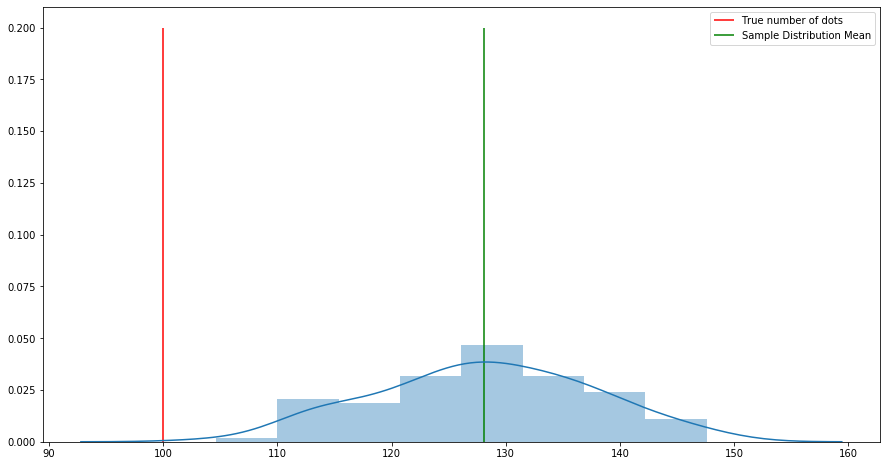

In [193]:
approximations = []
for i in range(100):
    n_approx = simple_probing(dots_clustrs, 1000, 0, 1)
    approximations.append(n_approx)

aprx = np.array(approximations)
sd_mean = aprx.mean();
sd_std = aprx.std();
print("Sample Distribution Mean: %.2f" % sd_mean)
print("Sample Distribution STD: %.2f" % sd_std)
plot_sample_dist(aprx, N)

## Interval Inception

Let's try to divide the interval into... more intervals! And maybe our accuracy will improve.

![InceptionURL](https://media.giphy.com/media/lBtI8rRETmQMg/giphy.gif "inception")

Let's divide the main interval into $m$ subintervals and probe each of them separately.

In [187]:
def create_intervals(m):
    step = 1 / m
    interval_borders = np.arange(0,1 + step, step).round(3)
    intervals = [(i,j) for i,j in zip(interval_borders, interval_borders[1:])]
    return intervals


def interval_sampling(dots, n_intervals = 10, n_runs = 10, n_probes = 100):
    results = []
    for i in range(n_runs):
        intervals = create_intervals(n_intervals)
        interval_approximations = []
        for (a,b) in intervals:
            intv_approx = simple_probing(dots,n_probes,a,b)
            interval_approximations.append(intv_approx)

        np_ia = np.array(interval_approximations)
        n_approx = np_ia.mean()
        results.append(n_approx)
    
    return results

### Interval Sampling on Uniform Interval

Sample Distribution Mean: 108.31
Sample Distribution STD: 1.69


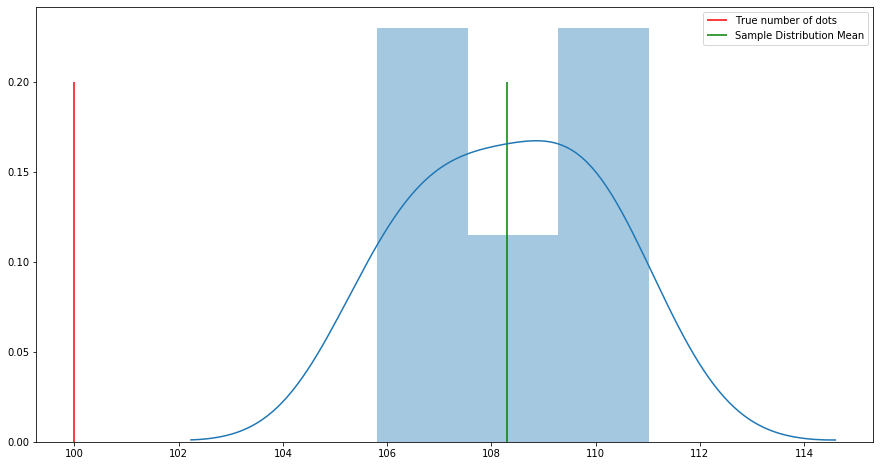

In [194]:
aprx = np.array(interval_sampling(dots))
sd_mean = aprx.mean();
sd_std = aprx.std();
print("Sample Distribution Mean: %.2f" % sd_mean)
print("Sample Distribution STD: %.2f" % sd_std)
plot_sample_dist(aprx, N)

### Interval Sampling on Gaussian Interval

Sample Distribution Mean: 116.93
Sample Distribution STD: 4.00


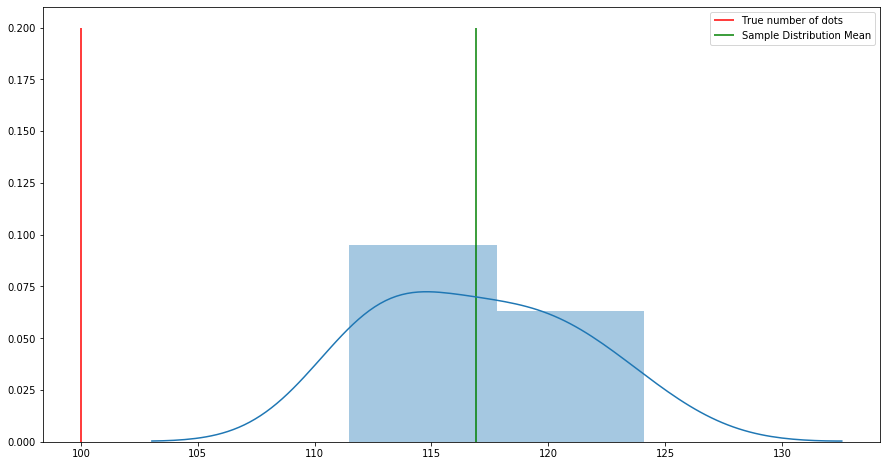

In [198]:
is_gauss = interval_sampling(dots_gauss, n_intervals=10, n_probes=100)
aprx = np.array(is_gauss)
sd_mean = aprx.mean();
sd_std = aprx.std();
print("Sample Distribution Mean: %.2f" % sd_mean)
print("Sample Distribution STD: %.2f" % sd_std)
plot_sample_dist(aprx, N)

Hmmm, so we get a bit better approximation using intervals

### Interval Sampling on Clustered Interval

Sample Distribution Mean: 201.10
Sample Distribution STD: 16.19


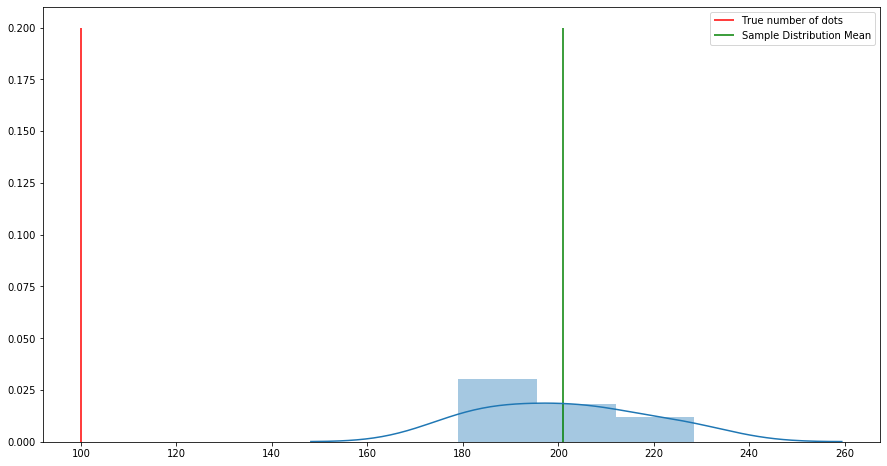

In [200]:
is_clustr = interval_sampling(dots_clustrs, n_intervals=8, n_probes=100)
aprx = np.array(is_clustr)
sd_mean = aprx.mean();
sd_std = aprx.std();
print("Sample Distribution Mean: %.2f" % sd_mean)
print("Sample Distribution STD: %.2f" % sd_std)
plot_sample_dist(aprx, N)